# Problem Set 5:  Exploring Hebbian Dynamics
Sam Greydanus  $\cdot$  Dartmouth College  $\cdot$  Jeremy Manning's PSYC 051.09  $\cdot$  16 February 2017  $\cdot$  MIT License

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

### Initialize parameters
Initialize memory vectors **m** probe vectors **x**

In [93]:
dim = 6
noise_sigma = .5
max_updates = 10
epsilon = 1e-8
m = [[ 1,-1,-1, 1,-1,-1],
     [-1,-1, 1,-1,-1, 1],]
x = [[-1,-1, 0, 0, 0, 0],
     [ 1,-1, 0, 0, 0, 0],]

m = [np.asarray(m_i, dtype=np.float32) for m_i in m]
x = [np.asarray(x_i, dtype=np.float32) for x_i in x]

## Problem 1: Build weight matrix
### Learning rule
Update the weight matrix using the "fire together wire together" learning rule (outer product)
$$W(i,j)=\sum_{k=1}^L a_k(i) a_k(j)$$

In [96]:
E = 1 - np.eye(dim)
hebbs = [np.expand_dims(m_i,1)*np.expand_dims(m_i,0)*E for m_i in m]
W = np.sum(hebbs,axis=0)

[[ 0.  0. -2.  2.  0. -2.]
 [ 0.  0.  0.  0.  2.  0.]
 [-2.  0.  0. -2.  0.  2.]
 [ 2.  0. -2.  0.  0. -2.]
 [ 0.  2.  0.  0.  0.  0.]
 [-2.  0.  2. -2.  0.  0.]]


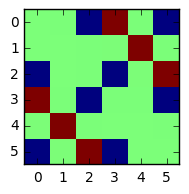

In [97]:
plt.figure(figsize=[2,2])
plt.imshow(W,interpolation='none')
print W ; plt.show()

## Problem 2: Probe the network
### Dynamic rule
$$a(i) = \mathbf{sgn} \left( \sum_{j=1}^N W(j,i) a(j) \right)$$

In [98]:
def add_noise(a, sigma):
    return a + np.random.randn(len(a))*sigma

def dynamic_rule(W, p, ix_async=None, sigma=0):
    p = add_noise(p, sigma)
    if ix_async is None:
        a = np.sign(np.dot(W, p) + epsilon)
    else:
        a = p.copy() ; a[ix_async] = np.sign(np.dot(W[ix_async,:], p) + epsilon)
    a_equals_p = np.allclose(p,a)
    return a, a_equals_p

Now, we'll probe the network (asynchronously) with the **x** vectors

In [99]:
def probe_network(W, p):
    aep_all = False # "the probe and activation vector match for all elements"
    aep_sum = True # "a[i] and p[i] have matched for all elements so far in a given cycle"
    i = 0
    while not aep_all and i < max_updates:
        print "\tstep {}, activation: {}".format(i, p)
        index_asynchronous = 2 + i%4 # cyclically update indices 2,3,4,5
        p, aep = dynamic_rule(W, p, ix_async=index_asynchronous)
        i += 1
        aep_sum = aep_sum and aep
        if i%4 == 0:
            aep_all = aep_sum ; aep_sum = True
    a = p ; print "{} updates produced {}\n".format(i, a)
    return a

In [100]:
a = [probe_network(W, x[i]) for i in range(len(x))]
a = a[::-1] # first two indices of second probe appear to match first two indices of first memory / vice versa
diff = np.vstack(m) - np.vstack(a)

print "Did we make errors? Look at difference between original memories and probe activations.\n", diff
print "\t\t\t\t...we made {} errors!".format(int(np.sum(np.sign(diff))))

	step 0, activation: [-1. -1.  0.  0.  0.  0.]
	step 1, activation: [-1. -1.  1.  0.  0.  0.]
	step 2, activation: [-1. -1.  1. -1.  0.  0.]
	step 3, activation: [-1. -1.  1. -1. -1.  0.]
	step 4, activation: [-1. -1.  1. -1. -1.  1.]
	step 5, activation: [-1. -1.  1. -1. -1.  1.]
	step 6, activation: [-1. -1.  1. -1. -1.  1.]
	step 7, activation: [-1. -1.  1. -1. -1.  1.]
8 updates produced [-1. -1.  1. -1. -1.  1.]

	step 0, activation: [ 1. -1.  0.  0.  0.  0.]
	step 1, activation: [ 1. -1. -1.  0.  0.  0.]
	step 2, activation: [ 1. -1. -1.  1.  0.  0.]
	step 3, activation: [ 1. -1. -1.  1. -1.  0.]
	step 4, activation: [ 1. -1. -1.  1. -1. -1.]
	step 5, activation: [ 1. -1. -1.  1. -1. -1.]
	step 6, activation: [ 1. -1. -1.  1. -1. -1.]
	step 7, activation: [ 1. -1. -1.  1. -1. -1.]
8 updates produced [ 1. -1. -1.  1. -1. -1.]

Did we make errors? Look at difference between original memories and probe activations.
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
				...we mad

## Extra fun: Energy landscapes

Professor Manning mentioned in class that the weight matrix $\mathbf{W}$ can be thought of in terms of an energy landscape; probes naturally gravitate to "low-energy" states, producing activations which resemble the original memories.

Can we visualize this? Of course...but it's tough because $\mathbf{m}, \mathbf{x}, \mathbf{a} \in R^{n}$ where $n >>2$. This means we'll need to reduce dimensionality. The best way to do this would be PCA, tSNE, or a related method. However, since I'm lazy I'll use a matrix of random values to reduce dimensionality. There are theoretical guarantees that this works "most of the time."

We also need to get rid of the **sgn** function because we need a smooth similarity measure between probes and activations. This certainly changes the dynamics of the system...but for this hand-wavy demo it's probably ok.

### Build a new 7-dimensional weight matrix

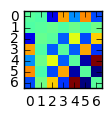

In [108]:
dim = 7
num_probes = 2
memories = [np.random.randn(dim) for _ in range(num_probes)]
E = 1 - np.eye(dim)
hebbs = [np.expand_dims(m_i,1)*np.expand_dims(m_i,0)*E for m_i in memories]
W = np.sum(hebbs,axis=0)
plt.figure(figsize=[1,1])
plt.imshow(W, interpolation='none')

### Helper functions
Note that our dynamic rule is synchronous and lacks the **sgn** function

In [109]:
def add_noise(a, sigma):
    return a + np.random.randn(len(a))*sigma

def norm(u):
    return np.sqrt(np.sum(np.square(u)))

def similarity(u,v):
    return np.dot(u,v) / (norm(u)*norm(v))

def dynamic_rule(W, p, sigma=0):
    p = add_noise(p, sigma)
    a = np.dot(W, p)
    a_equals_p = np.allclose(p,a)
    return a, a_equals_p

def interp1D(value, min, max, resolution):
    return int((value-min-epsilon)*resolution/(max-min))

def get_transformation_matrix(dim):
    R = np.random.randn(dim, 2) # cave man dimensionality reduction :)
    return R

### Repeatedly probe W with random vectors
Here we're measuring the similarity between the probe and the activation after one dynamic rule update. The idea is that the similarity should be larger for vectors near the original memories (these vectors will be more strongly attracted)

In [110]:
probes = []
similarities = []
num_probes = 100000
for _ in range(num_probes):
    probe = np.random.randn(dim)
    a_probe, _ = dynamic_rule(W, probe)
    in_out_similarity = similarity(probe, a_probe)
    probes.append(probe)
    similarities.append(in_out_similarity)

In [111]:
def transform_to_2d(probes, memories):
    R = get_transformation_matrix(dim)
    mem2d = np.dot(np.vstack(memories), R)
    ps2d = np.dot(np.vstack(probes), R)
    return ps2d, mem2d
    
def make_heatmap(xyz, mem2d, resolution):
    Q = np.zeros((resolution,resolution))
    mcoords = []
    minx, maxx = np.min(xyz['x']), np.max(xyz['x'])
    miny, maxy = np.min(xyz['y']), np.max(xyz['y'])
    
    for i in range(len(xyz['x'])):
        m = interp1D(xyz['x'][i], minx, maxx, resolution)
        n = interp1D(xyz['y'][i], miny, maxy, resolution)
        Q[m,n] = xyz['z'][i]
        
    for i in range(len(mem2d)):
        m = interp1D(mem2d[i,0], minx, maxx, resolution)
        n = interp1D(mem2d[i,1], miny, maxy, resolution)
        mcoords.append((m,n))
        
    return Q, mcoords

### Visualize in 2D
Having reduced the dimensionality of everything, we can plot the cloud in 2 dimensions. Note that the black dots are usually near the similarity "hot spots", aka the areas where probes changed more dramatically.

You won't see this pattern every time owing to 1) my primitive dimensionality reduction and 2) the fact that I'm not directly measuring energy...I'm looking at how much a given probe differs from its activation, which _might_ have a loose correlation with the energy landscape

[]

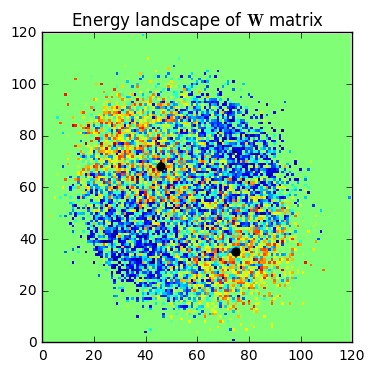

In [122]:
resolution = 120
ps2d, mem2d = transform_to_2d(probes, memories)
xyz = {'x': ps2d[:,0], 'y': ps2d[:,1], 'z': np.vstack(similarities)[:,0]}
Q, mcoords = make_heatmap(xyz, mem2d, resolution=resolution)


fig, ax = plt.subplots(1)
plt.title("Energy landscape of $\mathbf{W}$ matrix")
ax.imshow(Q, interpolation='none')

for i in range(len(mcoords)):
    rect = patches.Circle(mcoords[i],1.5,linewidth=1,edgecolor='k',facecolor='k')
    ax.add_patch(rect)
ax.set_ylim([0,resolution]) ; ax.set_xlim([0,resolution])

plt.plot()